In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

In [2]:
filenames = [f for f in glob.glob("*.fits")]
SPECTRA = [fits.open(f) for f in filenames]

In [3]:
len(SPECTRA[0][1].data)

86

In [4]:
len(filenames)

106

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


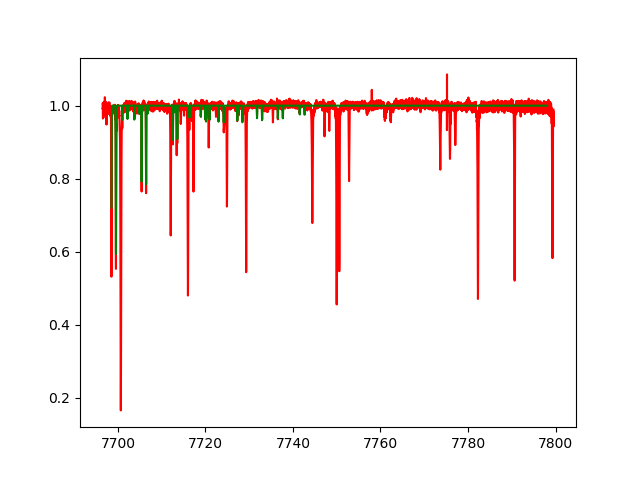

In [6]:
od = 81
plt.plot(SPECTRA[0][1].data[od][12], SPECTRA[0][0].data[od,:], c='r')
plt.plot(SPECTRA[0][1].data[od][12],SPECTRA[0][1].data[od][10], c='g')
plt.show()

In [15]:
#MASK OUT ALL PIXELS WHERE TELLURIC MODEL IS BELOW A CERTAIN THRESHOLD AND DIVIDE OUT THE REST
#threshold = 1.0
#TCFlux = np.ones((len(SPECTRA), len(SPECTRA[0][0].data[:,0]), len(SPECTRA[0][1].data[50][1])))
#TCFlux[:,:,:] = np.nan
#Goodindex = [[np.where((SPECTRA[tau][1].data[od][10] >= threshold) &
#                       ((SPECTRA[tau][1].data[od][12] < 5860) | (SPECTRA[tau][1].data[od][12] > 5915)) &
#                       (SPECTRA[tau][0].data[od,:] >= 0) &
#                       (~np.isnan(SPECTRA[tau][0].data[od,:]))&
#                       (SPECTRA[tau][0].data[od,:] < 2))[0] for od in range(len(SPECTRA[0][0].data[:,0]))] for tau in range(len(SPECTRA))]
#for tau in range(len(SPECTRA)):
#    for od in range(len(SPECTRA[0][0].data[:,0])):
#        #keep = np.where((SPECTRA[tau][1].data[od+23][10] >= threshold) &
#        #               ((SPECTRA[tau][1].data[od+23][12] < 5860) | (SPECTRA[tau][1].data[od+23][12] > 5915)) &
#        #               (SPECTRA[tau][0].data[od+23,:] >= 0) &
#        #               (~np.isnan(SPECTRA[tau][0].data[od+23,:]))&
#        #               (SPECTRA[tau][0].data[od+23,:] < 2))[0]
#        rightends = np.where(Goodindex[tau][od][1:] - Goodindex[tau][od][:-1] != 1)[0]
#        leftends = rightends + 1
#        rightends = np.hstack((rightends, len(Goodindex[tau][od])-1))
#        leftends = np.hstack((0, leftends))
#        keep = []
#        for i in range(len(leftends)):
#            if rightends[i] + 1 - leftends[i] > 30:
#                keep = keep + list(np.arange(leftends[i], rightends[i]+1))
#        Goodindex[tau][od] = Goodindex[tau][od][keep]
#        TCFlux[tau, od, Goodindex[tau][od]] = SPECTRA[tau][0].data[od,Goodindex[tau][od]]/SPECTRA[tau][1].data[od][10][Goodindex[tau][od]]

C:\Users\holze\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
C:\Users\holze\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


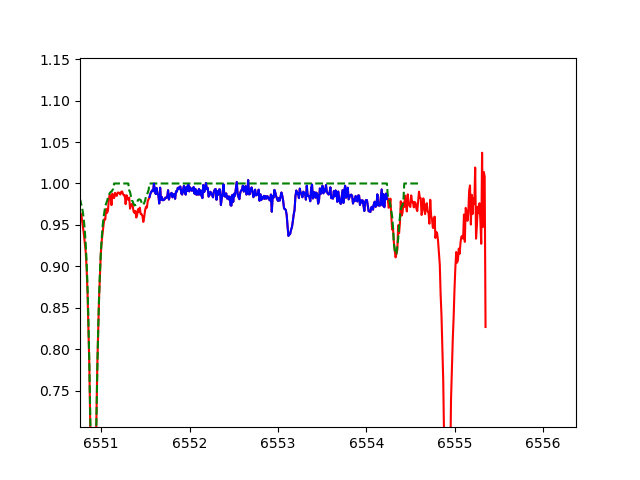

In [12]:
od = 66
plt.plot(SPECTRA[0][1].data[od][12], SPECTRA[0][0].data[od,:], c='r')
plt.plot(SPECTRA[0][1].data[od][12],SPECTRA[0][1].data[od][10], c='g', ls='--')
plt.plot(SPECTRA[0][1].data[od][12], TCFlux[0, od, :], c='b')
plt.show()

## Stitch Orders Together

In [6]:
from wave_match import wave_match2

In [11]:
threshold = 1.0
#tau = 0
for tau in range(len(SPECTRA)):
    print(tau)
    #od = 39
    WVL = []
    FLX = []
    UNC = []
    for od in range(23,82):
        keep0 = np.where(~np.isnan(SPECTRA[tau][0].data[od-1,:]))[0]
        keep0 = keep0[np.where((SPECTRA[tau][0].data[od-1,:][keep0] >= 0) & (SPECTRA[tau][0].data[od-1,:][keep0] < 2))[0]]
        keep1 = np.where(~np.isnan(SPECTRA[tau][0].data[od,:]))[0]
        keep1 = keep1[np.where((SPECTRA[tau][0].data[od,:][keep1] >= 0) & (SPECTRA[tau][0].data[od,:][keep1] < 2))[0]]
        keep2 = np.where(~np.isnan(SPECTRA[tau][0].data[od+1,:]))[0]
        keep2 = keep2[np.where((SPECTRA[tau][0].data[od+1,:][keep2] >= 0) & (SPECTRA[tau][0].data[od+1,:][keep2] < 2))[0]]

        lower = np.max(SPECTRA[tau][1].data[od-1][12][keep0])
        upper = np.min(SPECTRA[tau][1].data[od+1][12][keep2])
        between = np.where((SPECTRA[tau][1].data[od][12][keep1] > lower) & 
                           (SPECTRA[tau][1].data[od][12][keep1] < upper))[0]
        overlap = np.where(SPECTRA[tau][1].data[od][12][keep1] >= upper)[0]

        assert len(np.where(np.isnan(SPECTRA[tau][1].data[od][10][keep1][between]))[0]) == 0
        gdidx = np.where(SPECTRA[tau][1].data[od][10][keep1][between] >= threshold)[0]
        WVL = WVL + list(SPECTRA[tau][1].data[od][12][keep1][between])
        tempflx1 = np.array([np.nan]*len(between))
        tempunc1 = np.array([np.nan]*len(between))
        tempflx1[gdidx] = SPECTRA[tau][0].data[od,keep1][between][gdidx]/SPECTRA[tau][1].data[od][10][keep1][between][gdidx]
        tempunc1[gdidx] = SPECTRA[tau][1].data[od][2][keep1][between][gdidx]/SPECTRA[tau][1].data[od][10][keep1][between][gdidx]
        FLX = FLX + list(tempflx1)
        UNC = UNC + list(tempunc1)

        tel1 = SPECTRA[tau][1].data[od][10][keep1][overlap]
        nans = np.where(np.isnan(tel1))[0]
        tel1[nans] = 0
        gdidx = np.where(tel1 > 0)[0]
        tempflx1 = np.array(list(SPECTRA[tau][0].data[od, keep1][overlap]))
        tempunc1 = np.array(list(SPECTRA[tau][1].data[od][2][keep1][overlap]))
        tempflx1[gdidx] = tempflx1[gdidx]/tel1[gdidx]
        tempunc1[gdidx] = tempunc1[gdidx]/tel1[gdidx]
        lweights = np.zeros(len(overlap))
        gdidx = np.where(tel1 >= threshold)[0]
        lweights[gdidx] = np.interp(SPECTRA[tau][1].data[od][12][keep1][overlap][gdidx], 
                         [upper, np.max(SPECTRA[tau][1].data[od][12][keep1])], [0.95, 0.05])
        overlap2 = np.where(SPECTRA[tau][1].data[od+1][12][keep2] <= 2*np.max(SPECTRA[tau][1].data[od][12][keep1]))[0]
        tel2 = SPECTRA[tau][1].data[od+1][10][keep2][overlap2]
        nans = np.where(np.isnan(tel2))[0]
        tel2[nans] = 0
        gdidx = np.where(tel2 > 0)[0]
        tempflx2 = np.array(list(SPECTRA[tau][0].data[od+1, keep2][overlap2]))
        tempunc2 = np.array(list(SPECTRA[tau][1].data[od+1][2][keep2][overlap2]))
        tempflx2[gdidx] = tempflx2[gdidx]/tel2[gdidx]
        tempunc2[gdidx] = tempunc2[gdidx]/tel2[gdidx]
        tempflx2 = wave_match2(SPECTRA[tau][1].data[od+1][12][keep2][overlap2].astype(np.float64), 
                               tempflx2.astype(np.float64),
                              SPECTRA[tau][1].data[od][12][keep1][overlap].astype(np.float64))
        tempunc2 = wave_match2(SPECTRA[tau][1].data[od+1][12][keep2][overlap2].astype(np.float64), 
                               tempunc2.astype(np.float64),
                              SPECTRA[tau][1].data[od][12][keep1][overlap].astype(np.float64))
        uweights = 1 - lweights
        gdidx = np.where(tel2 >= threshold)[0]
        leftcutoffs = np.where((tel2[:-1] >= threshold) & (tel2[1:] < threshold))[0]
        if tel2[0] < threshold:
            leftcutoffs = np.array([0] + list(leftcutoffs))
        rightcutoffs = np.where((tel2[:-1] < threshold) & (tel2[1:] >= threshold))[0] + 1
        if tel2[-1] < threshold:
            rightcutoffs = np.array(list(rightcutoffs) + [-1])

        for i in range(len(leftcutoffs)):
            bdidx = np.where((SPECTRA[tau][1].data[od][12][keep1][overlap] >= SPECTRA[tau][1].data[od+1][12][keep2][overlap2][leftcutoffs][i]) & 
                         (SPECTRA[tau][1].data[od][12][keep1][overlap] <= SPECTRA[tau][1].data[od+1][12][keep2][overlap2][rightcutoffs][i]))[0]
            uweights[bdidx] = 0

        cflx = lweights*tempflx1 + uweights*tempflx2
        cunc = np.sqrt((lweights*tempunc1)**2 + (uweights*tempunc2)**2)
        gdidx = np.where((lweights == 0) & (uweights == 0))[0]
        cflx[gdidx] = np.nan
        cunc[gdidx] = np.nan
        gdidx = np.where((lweights == 0) & (uweights != 0))[0]
        cflx[gdidx] = tempflx2[gdidx]
        cunc[gdidx] = tempunc2[gdidx]
        gdidx = np.where((lweights != 0) & (uweights == 0))[0]
        cflx[gdidx] = tempflx1[gdidx]
        cunc[gdidx] = tempunc1[gdidx]
        WVL = WVL + list(SPECTRA[tau][1].data[od][12][keep1][overlap])
        FLX = FLX + list(cflx)
        UNC = UNC + list(cunc)
    
    FLX = np.array(FLX)
    UNC = np.array(UNC)
    WVL = np.array(WVL)
    bdidx = np.where((WVL >= 5860) & (WVL <= 5915))[0]
    FLX[bdidx] = np.nan
    UNC[bdidx] = np.nan
    
    assert len(np.where(np.isnan(FLX))[0]) < len(FLX)
    Spec = pd.DataFrame({"Wavelength": WVL, "Flux": FLX, "Uncertainty": UNC})
    Spec.to_csv(filenames[tau].split('.f')[0] + 'ctd.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


<IPython.core.display.Javascript object>


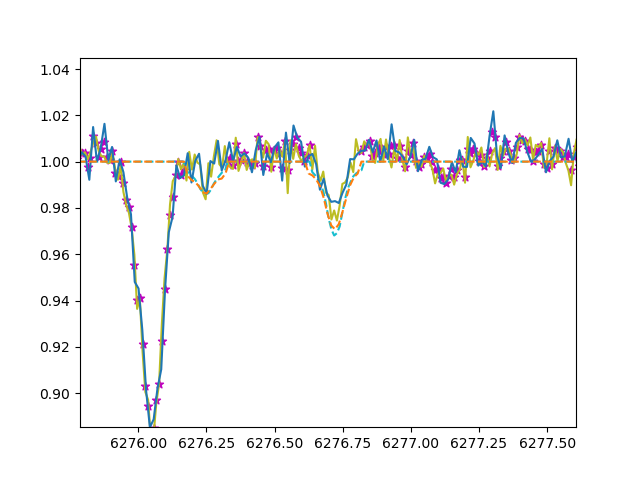

In [12]:
for od in range(23, 82):
    plt.plot(SPECTRA[-1][1].data[od][12], SPECTRA[-1][0].data[od,:])
    plt.plot(SPECTRA[-1][1].data[od][12], SPECTRA[-1][1].data[od][10], ls='--')
plt.scatter(WVL, FLX, marker='*', c='m')

#plt.plot(SPECTRA[0][1].data[40][12][keep2][overlap2], SPECTRA[0][1].data[40][10][keep2][overlap2])
#plt.plot(SPECTRA[tau][1].data[40][12][keep2][overlap2], uweights, c='g')
#plt.plot(SPECTRA[tau][1].data[39][12][keep1][overlap], uweights2, c='m')
#plt.plot(SPECTRA[0][1].data[40][12][keep2][overlap2], tel2)
#plt.scatter(SPECTRA[0][1].data[40][12][keep2][overlap2][gdidx], tel2[gdidx], marker='*', c='r')
#plt.plot(SPECTRA[0][1].data[39][12][keep1][overlap], uweights)
#plt.plot(SPECTRA[0][1].data[39][12][keep1][overlap], lweights)
#plt.scatter(SPECTRA[0][1].data[40][12][keep2][overlap2][leftcutoffs], tel2[leftcutoffs], marker='*', c='r')
#plt.scatter(SPECTRA[0][1].data[40][12][keep2][overlap2][rightcutoffs], tel2[rightcutoffs], marker='*', c='g')

#plt.vlines([lower, upper], ymin=0, ymax=1)
plt.show()

In [16]:
#tau = 0
#for tau in range(len(SPECTRA)):
#    WVL = np.array([])
#    FLX = np.array([])
#    UNC = np.array([])
#    for od in range(23, 82):
#        lower = np.max(SPECTRA[tau][1].data[od-1][12][Goodindex[tau][od-1]])
#        upper = np.min(SPECTRA[tau][1].data[od+1][12][Goodindex[tau][od+1]])
#        between = np.where((SPECTRA[tau][1].data[od][12][Goodindex[tau][od]] > lower) & 
#                       (SPECTRA[tau][1].data[od][12][Goodindex[tau][od]] < upper))[0]
#        overlap = np.where(SPECTRA[tau][1].data[od][12][Goodindex[tau][od]] >= upper)[0]
#        WVL = np.hstack((WVL, SPECTRA[tau][1].data[od][12][Goodindex[tau][od]][between]))
#        FLX = np.hstack((FLX, TCFlux[tau,od, Goodindex[tau][od][between]]))
#        UNC = np.hstack((UNC, SPECTRA[tau][1].data[od][2][Goodindex[tau][od]][between]/SPECTRA[tau][1].data[od][3][Goodindex[tau][od]][between]))
#        lweights = np.interp(SPECTRA[tau][1].data[od][12][Goodindex[tau][od]][overlap], 
#                         [upper, np.max(SPECTRA[tau][1].data[od][12][Goodindex[tau][od]])], [0.95, 0.05])
#        uweights = 1 - lweights
#        lflx = TCFlux[tau, od, Goodindex[tau][od][overlap]]
#        lunc = SPECTRA[tau][1].data[od][2][Goodindex[tau][od]][overlap]/SPECTRA[tau][1].data[od][3][Goodindex[tau][od]][overlap]
#        overlap2 = np.where(SPECTRA[tau][1].data[od+1][12][Goodindex[tau][od+1]] <= 2*np.max(SPECTRA[tau][1].data[od][12][Goodindex[tau][od]]))[0]
#        uflx = np.array(len(overlap)*[np.nan])
#        uunc = np.array(len(overlap)*[np.nan])
#        lrightends = np.where(Goodindex[tau][od][overlap][1:] - Goodindex[tau][od][overlap][:-1] != 1)[0]
#        lleftends = lrightends + 1
#        lrightends = np.hstack((lrightends, len(Goodindex[tau][od][overlap])-1))
#        lleftends = np.hstack((0, lleftends))
#        
#        
#        uflx = wave_match2(SPECTRA[tau][1].data[od+1][12][Goodindex[tau][od+1]][overlap2].astype(np.float64), 
#                       TCFlux[tau, od+1, Goodindex[tau][od+1][overlap2]],
#                          SPECTRA[tau][1].data[od][12][Goodindex[tau][od]][overlap].astype(np.float64))
#        uunc = wave_match2(SPECTRA[tau][1].data[od+1][12][Goodindex[tau][od+1]][overlap2].astype(np.float64), 
#                       SPECTRA[tau][1].data[od+1][2][Goodindex[tau][od+1]][overlap2]/SPECTRA[tau][1].data[od+1][3][Goodindex[tau][od+1]][overlap2],
#                          SPECTRA[tau][1].data[od][12][Goodindex[tau][od]][overlap].astype(np.float64))
#        FLX = np.hstack((FLX, lweights*lflx + uweights*uflx))
#        WVL = np.hstack((WVL, SPECTRA[tau][1].data[od][12][Goodindex[tau][od]][overlap]))
#        UNC = np.hstack((UNC, np.sqrt((lweights*lunc)**2 + (uweights*uunc)**2)))
#    od = 82
#    lower = np.max(SPECTRA[tau][1].data[od-1][12][Goodindex[tau][od-1]])
#    upper = np.max(SPECTRA[tau][1].data[od][12][Goodindex[tau][od]])
#    between = np.where((SPECTRA[tau][1].data[od][12][Goodindex[tau][od]] > lower) & 
#                   (SPECTRA[tau][1].data[od][12][Goodindex[tau][od]] < upper))[0]
#    WVL = np.hstack((WVL, SPECTRA[tau][1].data[od][12][Goodindex[tau][od]][between]))
#    FLX = np.hstack((FLX, TCFlux[tau,od,Goodindex[tau][od][between]]))
#    UNC = np.hstack((UNC, SPECTRA[tau][1].data[od][2][Goodindex[tau][od]][between]/SPECTRA[tau][1].data[od][3][Goodindex[tau][od]][between]))
#    
#    if tau == 0:
#        basewvl = np.array(list(WVL))
#        
#    else:
#        WVL = np.array(list(WVL[0] + np.arange(-99,0)*(WVL[1] - WVL[0])) + list(WVL) + 
#                       list(WVL[-1] + np.arange(1,100)*(WVL[-1] - WVL[-2])))
#        FLX = np.array(list(np.ones(99)) + list(FLX) + list(np.ones(99)))
#        UNC = np.array(list(np.mean(UNC)*np.ones(99)) + list(UNC) + list(np.mean(UNC)*np.ones(99)))
#        FLX = wave_match2(WVL, FLX, basewvl)
#        UNC = wave_match2(WVL, UNC, basewvl)
#        WVL = np.array(list(basewvl))
#    assert len(np.where(np.isnan(FLX))[0]) < len(FLX)
#    Spec = pd.DataFrame({"Wavelength": WVL, "Flux": FLX, "Uncertainty": UNC})
#    Spec.to_csv(filenames[tau].split('.f')[0] + 'ctd.csv')

In [18]:
[np.nan]*5

[nan, nan, nan, nan, nan]

<IPython.core.display.Javascript object>


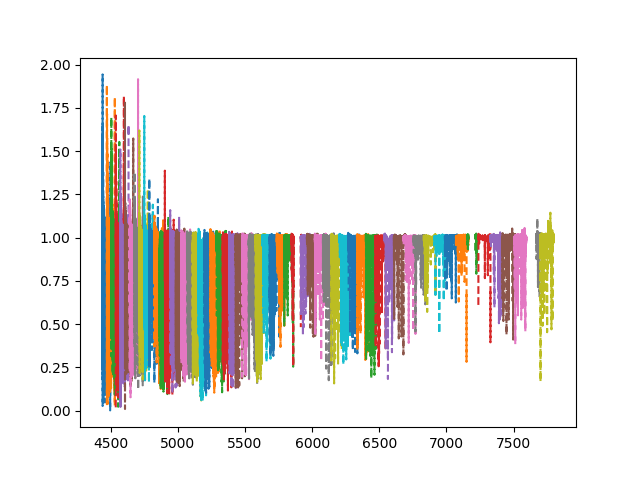

In [14]:

for od in range(23, 82):
    plt.plot(SPECTRA[tau][1].data[od][12], TCFlux[tau,od,:], ls='--')
plt.plot(Spec.Wavelength.values, Spec.Flux.values)
plt.scatter(Spec.Wavelength.values, Spec.Flux.values + 2*Spec.Uncertainty.values, marker='_', c='k')
plt.scatter(Spec.Wavelength.values, Spec.Flux.values - 2*Spec.Uncertainty.values, marker='_', c='k')
plt.show()

<IPython.core.display.Javascript object>


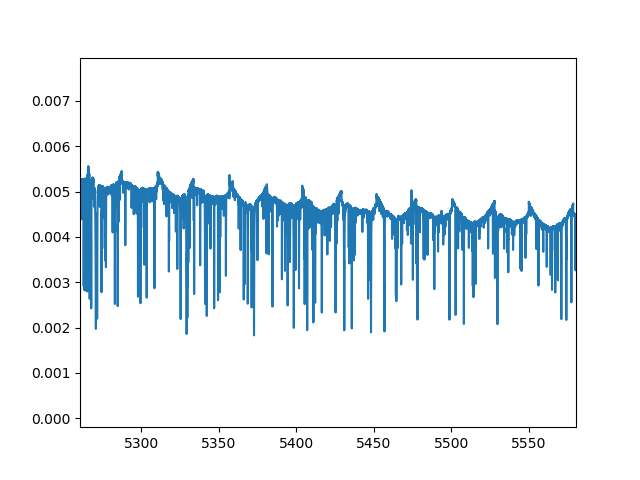

In [12]:
plt.plot(Spec.Wavelength.values, Spec.Uncertainty.values)
plt.show()

In [8]:
practice = pd.read_csv("10700_190825.1208ctd.csv")

<IPython.core.display.Javascript object>


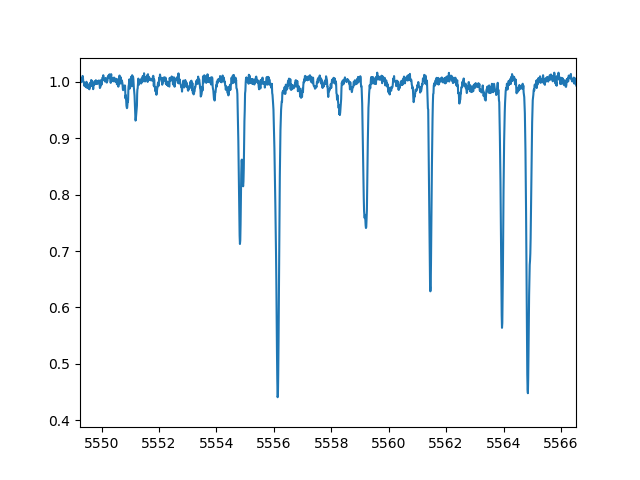

In [9]:
plt.plot(practice.Wavelength.values, practice.Flux.values)
plt.show()